# TRANSFER LEARNING


<img src="images/transfert.png">

## IMPORTER LES LIBRAIRIES

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split

## DEFINIR LES PARAMETRES

In [7]:
CATEGORIES = ["Chien", "Chat"]


### CHARGEMENT DES DONNEES

In [8]:
#Import des images
pickle_in = open("datasets/features.pickle","rb")
features = pickle.load(pickle_in)


#Import des labels
pickle_in = open("datasets/labels.pickle","rb")
labels = pickle.load(pickle_in)
labels= np.array(labels)


### VERIFICATION DES DONNES IMPORTEES

Text(0.5, 1.0, 'Chien')

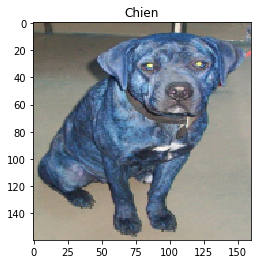

In [32]:
plt.figure()
plt.imshow(features[1200])
plt.title(CATEGORIES[labels[1200]])

### MISE EN PLACE DES JEUX DE DONNEES

In [34]:
#Création du jeu de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [35]:
# Création du jeu de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

In [36]:
X_train = X_train.astype("float32") / 127.5 -1
X_test = X_test.astype("float32") / 127.5 -1
X_val = X_val.astype("float32") / 127.5 -1

### CREATION DU MODELE

In [12]:
# On importe les modele MobileNet.V2 comme modèle de base
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [26]:
# On vient créer une couche de pooling
#sortie_conv = tf.keras.layers.Flatten()
#Option 2
sortie_conv =  tf.keras.Sequential()
sortie_conv.add(tf.keras.layers.GlobalAveragePooling2D())
#sortie_conv.add(tf.keras.layers.Flatten())
sortie_conv.add(tf.keras.layers.Dense(1))

In [15]:
# Couche dense de sortie
#prediction_layer = tf.keras.layers.Dense(1)

In [16]:
# On vient bloquer les poids du modèle de base
base_model.trainable = False


In [37]:
# On combine tout ça pour avoir notre modèle
model = tf.keras.Sequential([
  base_model,
  sortie_conv,
  
])

In [38]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val),
)

Train on 15715 samples, validate on 1747 samples
Epoch 1/10
15715/15715 [==============================] - 13s 819us/sample - loss: 0.6473 - accuracy: 0.6199 - val_loss: 0.4053 - val_accuracy: 0.8786
Epoch 2/10
15715/15715 [==============================] - 9s 584us/sample - loss: 0.3928 - accuracy: 0.8289 - val_loss: 0.2728 - val_accuracy: 0.9250
Epoch 3/10
15715/15715 [==============================] - 9s 587us/sample - loss: 0.2860 - accuracy: 0.8892 - val_loss: 0.2376 - val_accuracy: 0.9256
Epoch 4/10
15715/15715 [==============================] - 9s 589us/sample - loss: 0.2340 - accuracy: 0.9117 - val_loss: 0.2171 - val_accuracy: 0.9302
Epoch 5/10
15715/15715 [==============================] - 9s 592us/sample - loss: 0.2042 - accuracy: 0.9216 - val_loss: 0.1952 - val_accuracy: 0.9405
Epoch 6/10
15715/15715 [==============================] - 9s 592us/sample - loss: 0.1828 - accuracy: 0.9301 - val_loss: 0.1883 - val_accuracy: 0.9422
Epoch 7/10
15715/15715 [==========================

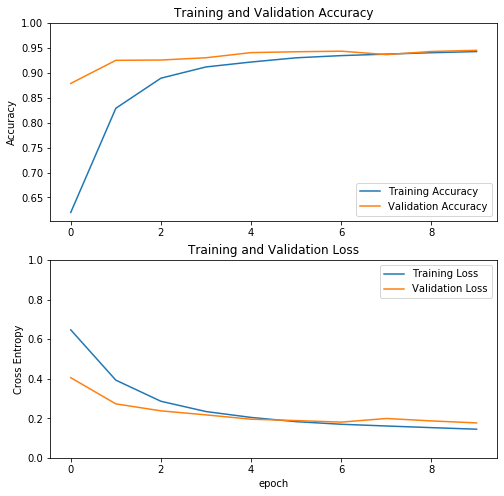

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## FINE TUNING

In [40]:
# On rend les poids initiaux modifiable
base_model.trainable = True

# Par contre on va préciser a partir de ou car pas besoin de modifier tous les poids
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False



In [41]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])


In [42]:

history_fine = model.fit( X_train,
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val),)


Train on 15715 samples, validate on 1747 samples
Epoch 1/10
15715/15715 [==============================] - 19s 1ms/sample - loss: 0.1141 - accuracy: 0.9570 - val_loss: 0.0889 - val_accuracy: 0.9714
Epoch 2/10
15715/15715 [==============================] - 12s 770us/sample - loss: 0.0779 - accuracy: 0.9724 - val_loss: 0.0762 - val_accuracy: 0.9760
Epoch 3/10
15715/15715 [==============================] - 12s 774us/sample - loss: 0.0591 - accuracy: 0.9790 - val_loss: 0.0714 - val_accuracy: 0.9760
Epoch 4/10
15715/15715 [==============================] - 12s 772us/sample - loss: 0.0443 - accuracy: 0.9854 - val_loss: 0.0696 - val_accuracy: 0.9754
Epoch 5/10
15715/15715 [==============================] - 12s 775us/sample - loss: 0.0341 - accuracy: 0.9900 - val_loss: 0.0666 - val_accuracy: 0.9748
Epoch 6/10
15715/15715 [==============================] - 12s 777us/sample - loss: 0.0277 - accuracy: 0.9919 - val_loss: 0.0658 - val_accuracy: 0.9777
Epoch 7/10
15715/15715 [=======================